# This notebook provides evaluation of the algorithm on ["email-Eu-core network"](http://snap.stanford.edu/data/email-Eu-core.html) dataset with ground-truth communities

In [1]:
from sten.embedding import DiGraphCSR, Systems, SysLeft, SystemRight
from matplotlib.pyplot import figure
import networkx as net
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import community

np.random.seed(19680801)

In [2]:
g = net.Graph()
with open("datasets/email-Eu-core.txt") as f:
    for line in f.readlines():
        u, v = line.split(" ")
        g.add_edge(int(u), int(v))



In [3]:
departments = {}
with open("datasets/email-Eu-core-department-labels.txt") as f:
    for line in f.readlines():
        u, department = line.split()
        departments[int(u)] = int(department)
departments_arr = np.array([departments[i] for i in range(len(departments))], dtype=np.int32)

In [4]:
embeddings = Systems(
    system=SysLeft(DiGraphCSR(g), 0.7),
    make_system_right=lambda n: SystemRight(DiGraphCSR(g), n),
    n_nodes=g.number_of_nodes(),
).results().T

# normalzie values
for i in range(embeddings.shape[1]):
    embeddings[:, i] /= embeddings[:, i].max()

# 42 -- number of the ground-turth clusters
kmeans = KMeans(n_clusters=42)
clustering = kmeans.fit(embeddings).labels_

/home/vhhlu/programs/miniconda3/envs/sne01/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [5]:
# Normalized mutual information (NMI) score
# for the generated clustering and the ground-truth communities

print("NMI score with ground truth: ", sklearn.metrics.normalized_mutual_info_score(departments_arr, clustering))

NMI score with ground truth:  0.6120898776330704


In [6]:
# Comparison with python-louvain best_partition communities
best_partition = community.best_partition(g)
bp = np.array([best_partition[i] for i in range(len(best_partition))])
print("NMI score between louvain best partition and the ground truth", sklearn.metrics.normalized_mutual_info_score(bp, departments_arr))

NMI score between louvain best partition and the ground truth 0.5659711913405314


In [7]:
# Aplying PCA dimensionality reduction to make possible 3d plotting
# of the generated embeddings

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(embeddings)
embeddings_ld = pca.transform(embeddings)
embeddings_ld.shape
# 42 -- number of the ground-turth clusters
kmeans_ld = KMeans(n_clusters=42)
clustering_ld = kmeans_ld.fit(embeddings_ld).labels_

In [8]:
print("NMI score with ground truth (PCA applied, 3 dimensions): ", sklearn.metrics.normalized_mutual_info_score(departments_arr, clustering))
print(sklearn.metrics.normalized_mutual_info_score(clustering_ld, departments_arr))

NMI score with ground truth (PCA applied, 3 dimensions):  0.6120898776330704
0.5297354177344872


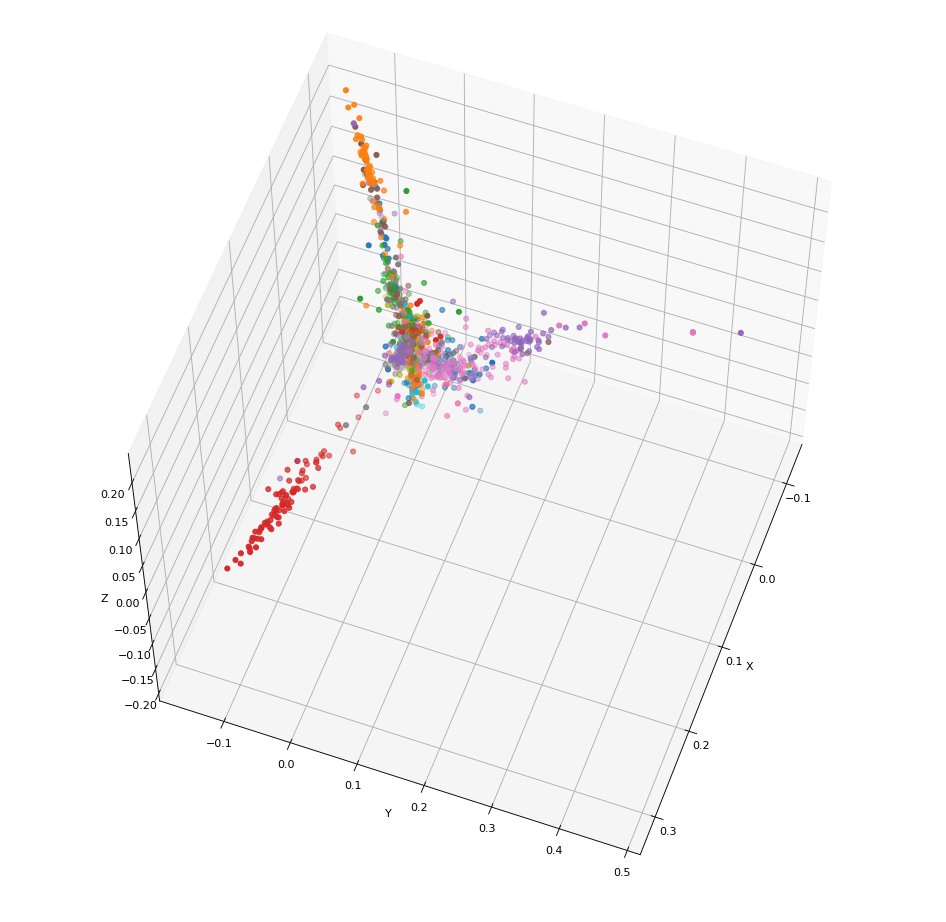

In [9]:
# Plot the the result of the PCA as 3d scatter plot
# Colors of the points represent the ground-truth department membership for each point

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15), dpi=80)
ax = fig.add_subplot(111, projection='3d')

departments = {}
for node, dept in enumerate(departments_arr):
    departments.setdefault(dept, []).append(
        embeddings_ld[node]
    )

for dept in departments.values():
    xs = np.array([x for x, y, z in dept])
    ys = np.array([y for x, y, z in dept])
    zs = np.array([z for x, y, z in dept])
    ax.scatter(xs, ys, zs)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# for angle in range(0, 360):
ax.view_init(60, 20)
plt.draw()

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(embeddings)

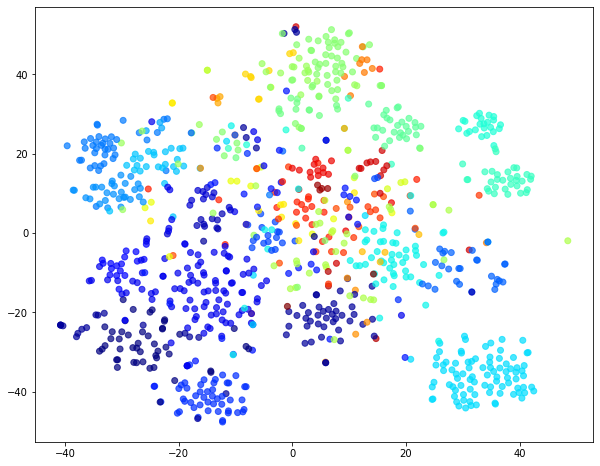

In [11]:

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=departments_arr,
    cmap="jet",
    alpha=0.7,
)